In [1]:
# Import nltk libraries and download
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
#Import the required libraries
import os
import pandas as pd
import numpy as np
import time
import warnings
from scipy import sparse
import scipy.stats as ss

#Import NLP related libraries
import string
import re
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

#Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn   


#Import libraries for Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#Import Keras and tensorflow libraries
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential

In [3]:
# A workaround in case some system may have locale issue when it cannot find UTF-8
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
# Download the train.csv from the google drive by providing its Unique ID
! gdown 1hdJ8HxCOeS7ZCtCGPLNfKoWt4h_8qJUV

Downloading...
From: https://drive.google.com/uc?id=1hdJ8HxCOeS7ZCtCGPLNfKoWt4h_8qJUV
To: /content/train.csv
100% 68.8M/68.8M [00:01<00:00, 48.6MB/s]


In [5]:
# Download the test.csv from the google drive by providing its Unique ID
! gdown 1F69UYJQKjFH3c3plbR4RTNZYDi18i-ar

Downloading...
From: https://drive.google.com/uc?id=1F69UYJQKjFH3c3plbR4RTNZYDi18i-ar
To: /content/test.csv
100% 60.4M/60.4M [00:00<00:00, 64.9MB/s]


In [6]:
#Set initial confugurations
start_time=time.time()
color = sns.color_palette()
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
%matplotlib inline

In [7]:
# Import the dataset that was downloaded
train_data=pd.read_csv("/content/train.csv")
test_data=pd.read_csv("/content/test.csv")

In [8]:
# Let us examine the data
train_data.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
72234,c1602a4deda9f645,"Wow, to come from both of you, I'm both reliev...",0,0,0,0,0,0
108667,44fde4ac2477bab9,"""\n\n Clear \nIt is abundantly clear that I wi...",0,0,0,0,0,0
8029,15653e7a7439b1c4,"""\n\nWikiWomen's Collaborative\n WikiWomen Uni...",0,0,0,0,0,0
6064,10309c57a2920ead,"""\n\n Sodom Yat Thank you for trying to be h...",0,0,0,0,0,0
39016,681320f4bad5471f,""" contents....""""\nFuture instances of same ref...",0,0,0,0,0,0
35005,5d7d05da756ed682,HumbleGod likes to fuck his horny cousins!,1,0,1,0,1,0
19820,3457da5a317cacb6,6000th GA \n\nAny idea what the 6000th GA was?...,0,0,0,0,0,0
113937,61603978509e7e76,Williams and Paisner books 2009 \n\nCan someon...,0,0,0,0,0,0
125636,a01784cae301f9c8,"""\n\n 2 pilot-episodes ?? \n\nI think """"Ransom...",0,0,0,0,0,0
133051,c7c2fcbd2fa5dfa5,"Thank you C.Fred. I am very new to this, hope...",0,0,0,0,0,0


In [9]:
# Let us check the total rows and precentage of data in train and test
rows_train=train_data.shape[0]
rows_test=test_data.shape[0]
total_rows =rows_train + rows_test
print("               Train     Test")
print("Total rows    ", rows_train,"  ",rows_test)
print("Percent       ",round(rows_train*100/total_rows),"      ",round(rows_test*100/total_rows))

               Train     Test
Total rows     159571    153164
Percent        51        49


### Let us now check if there is any class imbalance

In [10]:
# Let us determine the tags in comments and mark them as 'clean' if no tags
tags=train_data.iloc[:,2:].sum()
totalrows=train_data.iloc[:,2:].sum(axis=1)
train_data['clean']=(totalrows==0)

In [11]:
# Get the count of each
train_data['clean'].sum()
print("Total comments = ",len(train_data))
print("Total clean comments = ",train_data['clean'].sum())
print("Total tags =",tags.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [12]:
# Let us check for missing values in the Train dataset
print("Missing values in Train dataset")
missing_values=train_data.isnull().sum()
print(missing_values)

Missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64


In [13]:
# Let us check for missing values in the Test dataset
print("Missing values in Test dataset")
missing_values=test_data.isnull().sum()
print(missing_values)

Missing values in Test dataset
id              0
comment_text    0
dtype: int64


In [14]:
# Let us check for "NA" values in the Train dataset
na_values=train_data.isna().sum()
print(na_values)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64


In [15]:
# Let us check for "NA" values in the Test dataset
na_values=test_data.isna().sum()
print(na_values)

id              0
comment_text    0
dtype: int64


##### Hence we observe that there are no missing values and 'NA' values the the train and test dataset

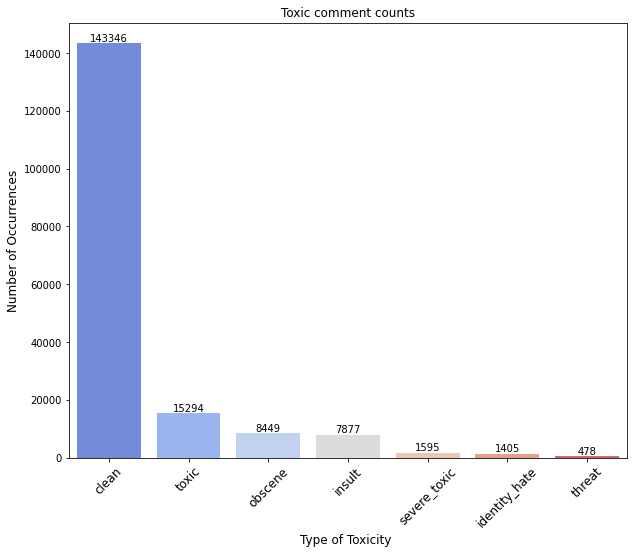

In [16]:
# Let us plot the occurence of different toxic comments
x_data=train_data.iloc[:,2:].sum().sort_values(ascending=False)
plt.figure(figsize=(10,8))
ax= sns.barplot(x_data.index, x_data.values, palette ='coolwarm')
plt.title("Toxic comment counts")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of Toxicity ', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
rects = ax.patches
labels = x_data.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

##### From the above graph we observe that the classes are not balanced as there are more number of non toxic or clean comments (approximately 86000). There are also approximately 21000 tags.

Since there are total of approximately 95000 comments in the train dataset hence we can say that there is a possibility of multiple tags being associated for a single comments in many instances which overlaps and can classified in more than one class, like for example a comment can be classified both as a 'toxic' and a 'threat'.

As we determined that there are possibily cases of multi-tagging hence let us analyze as how many comments are multi-tagged.

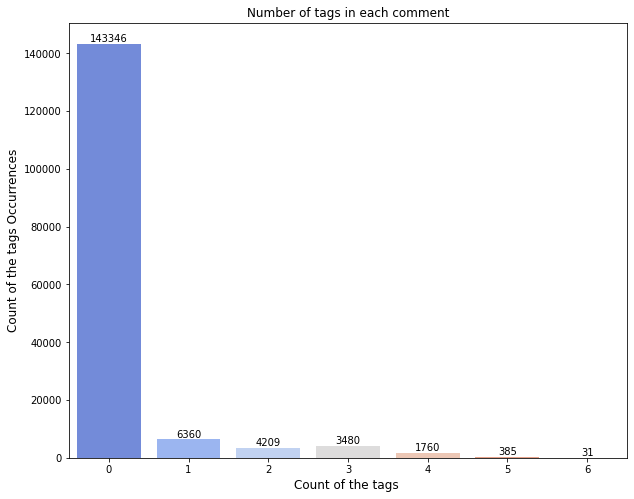

In [17]:
# Let us plot the occurence of multiple tags per comment
x_data=totalrows.value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,8))
ax = sns.barplot(x_data.index, x_data.values, palette ='coolwarm')
plt.title("Number of tags in each comment")
plt.ylabel('Count of the tags Occurrences', fontsize=12)
plt.xlabel('Count of the tags ', fontsize=12)
rects = ax.patches
labels = x_data.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

From the above graph we observe that near about 10% of the total comments are actually toxic. Some very few specific comments are tagged with all the tags.

Next let us analyze as which tags occur together and how many occurences of multiple tags are there.

To analyze this, a correlation matrix plot would be more suitable.

<AxesSubplot:>

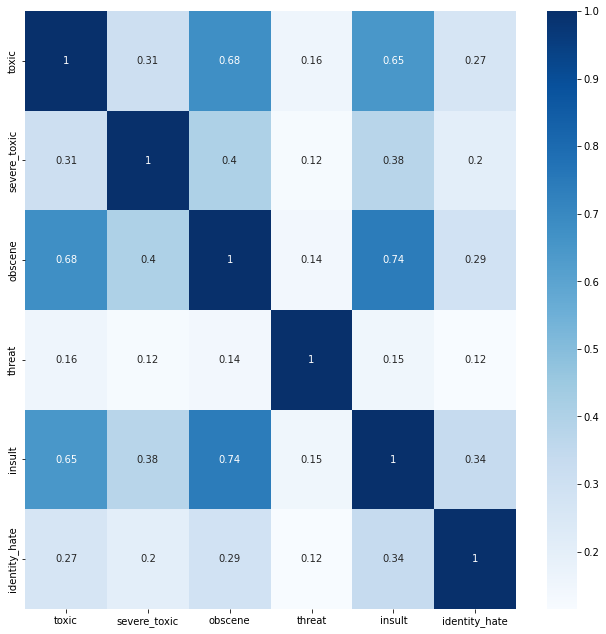

In [18]:
# Draw a correlation plot for analyzing multiple tags
data_df=train_data.iloc[:,2:-1]
corr=data_df.corr()
plt.figure(figsize=(11,11))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

The correlation plot above uses Pearson correlation, which may not be a correct correlation in this case since the feature variables in the dataset are binary categorical variable.
We can use Confusion Matrix or Crosstab to measure a more correct association.

In [19]:
 # Write a function that highlights the minimum with default green color
def min_hilighter(data, color='#00ff00'):
    hilight_color = 'background-color: {}'.format(color)
    if data.ndim == 1:
        is_min = data == data.min()
        return [hilight_color if v else '' for v in is_min]
    else:
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, hilight_color, ''),
                            index=data.index, columns=data.columns)

In [20]:
#Let us use Crosstab to compare toxic tag with other tags
corr_mats=[]
for cols in data_df.columns[1:]:
    confusion_matrix = pd.crosstab(data_df["toxic"], data_df[cols])
    corr_mats.append(confusion_matrix)
result = pd.concat(corr_mats,axis=1,keys=data_df.columns[1:])
result = result.style.apply(min_hilighter,axis=0)

In [21]:
# display result
result

The result above indicates that the Severe toxic comment is always categorized as toxic while other classes seem to be a subset of toxic except some.

Let us define function to calculate Cramers V statistic for categorial-categorial association. It uses correction from Bergsma and Wicher Journal of the Korean Statistical Society 42 (2013): 323-328

In [22]:
def cramers_v_statistics(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [23]:
# Examine Toxic and Severe toxic
toxic_col="toxic"
severe_toxic_col="severe_toxic"
confusion_matrix = pd.crosstab(data_df[toxic_col], data_df[severe_toxic_col])

In [24]:
# Display the confusion matrix between toxic and severe toxic
print(confusion_matrix)

severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595


In [25]:
# Display the correlation between Toxic and Severe toxic using Cramer's V stat
cramer_v_stat =cramers_v_statistics(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's V stat=", cramer_v_stat)

The correlation between Toxic and Severe toxic using Cramer's V stat= 0.30850290540548614


#### Let us now examine some random comments from each classes that are toxic

###### Toxic Comment

In [26]:
# Print the comment from class toxic
print(train_data[train_data.toxic==1].iloc[3,1])

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


###### Severe Toxic Comment

In [27]:
# Print the comment from class severe_toxic
print(train_data[train_data.severe_toxic==1].iloc[4,1])

What a motherfucking piece of crap those fuckheads for blocking us!


###### Threat Comment

In [28]:
# Print the comment from class 'threat'
print(train_data[train_data.threat==1].iloc[4,1])

WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.


###### Obscene Comment

In [29]:
# Print the comment from class 'obscene'
print(train_data[train_data.obscene==1].iloc[3,1])

GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!


###### Identity hate Comment

In [30]:
# Print the comment from class 'obscene'
print(train_data[train_data.identity_hate==1].iloc[9,1])

WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.


##### Well, after examining some of the comments above we do observe that some of the same comments are multi-tagged or repeated exactly. If we further examine then we also find that user names and IP addresses are also present in some comments which can result in overfitting.

#### Let us now visualize the frequency of words associated with each class

In [31]:
# initialize the stop words
stopword=set(STOPWORDS)

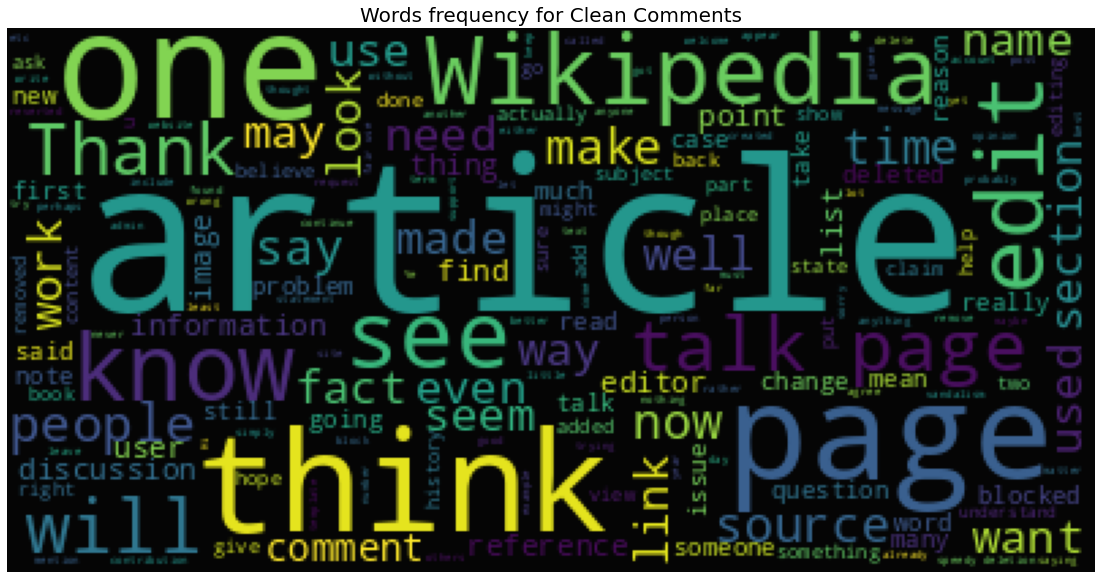

In [32]:
# Let us generate a wordcloud for the clean comments
subset=train_data[train_data.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequency for Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [33]:
# define a function for creating wordclouds for all toxic type and clean comments
def sublots(loc=1, type="toxic", cmp="gist_earth", title="Words frequency for Toxic Comments"):
  plt.subplot(3,2,loc)
  subset=train_data[train_data[type]==1]
  text=subset.comment_text.values
  wordcloud= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
  wordcloud.generate(" ".join(text))
  plt.axis("off")
  plt.title(title, fontsize=20)
  plt.imshow(wordcloud.recolor(colormap= cmp , random_state=244))

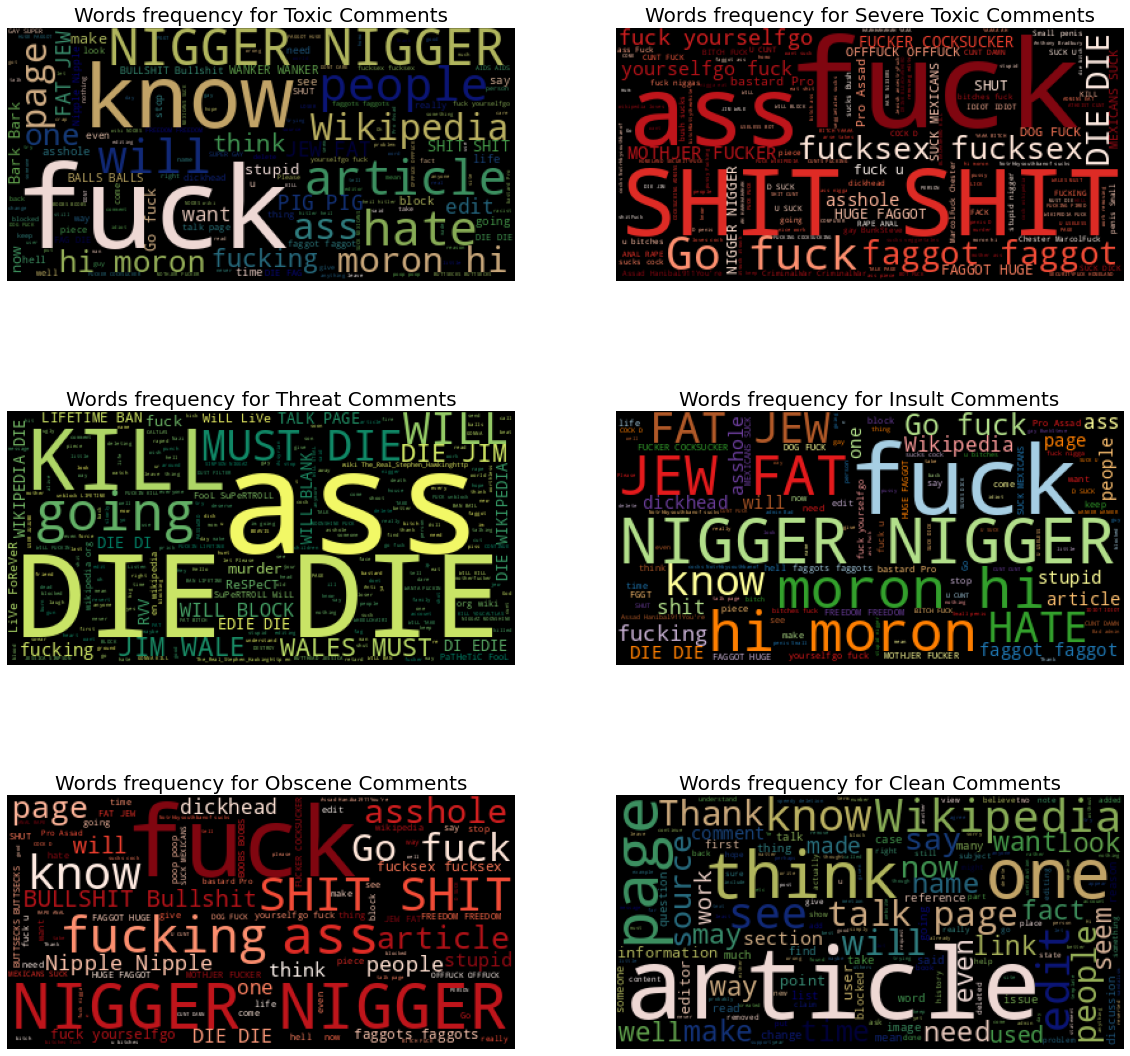

In [34]:
# Draw the plots for wordcloud
plt.figure(figsize=(20,20))
sublots()
sublots(2,"severe_toxic", "Reds","Words frequency for Severe Toxic Comments" )
sublots(3,"threat", "summer","Words frequency for Threat Comments" )
sublots(4,"insult","Paired_r","Words frequency for Insult Comments" )
sublots(5,"obscene", "Reds","Words frequency for Obscene Comments" )
sublots(6,"clean", "gist_earth","Words frequency for Clean Comments" )
plt.show()

## Feature Engineering

We will perform the following categories of Feature Engineering:
- Indirect Features
- Derived Features
- Leaky Features

In [35]:
# merge the train and test data first 3 columns
merged_df=pd.concat([train_data.iloc[:,0:2],test_data.iloc[:,0:2]])
df=merged_df.reset_index(drop=True)

#### Indirect Features

In [36]:
# Determine the sentence count in each comment and save it in column 'sentence_count'
df['sentence_count']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

# Determine the word count in each comment and save it in column 'word_count'
df['word_count']=df["comment_text"].apply(lambda x: len(str(x).split()))

# Determine the unique word count in each comment and save it in column 'unique_word_count'
df['unique_word_count']=df["comment_text"].apply(lambda x: len(set(str(x).split())))

# Determine the letter count in each comment and save it in column 'letter_count'
df['letter_count']=df["comment_text"].apply(lambda x: len(str(x)))

# Determine the punctuation count in each comment and save it in column 'punctuation_count'
df["punctuation_count"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Determine the upper case words count in each comment and save it in column 'upper_word_count'
df["upper_word_count"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Determine the title case words count in each comment and save it in column 'title_word_count'
df["title_word_count"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Determine the stop words count in each comment and save it in column 'stop_word_count'
df["stop_word_count"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# Determine the average length of the words in each comment and save it in column 'mean_word_length'
df["mean_word_length"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#### Derived Features

In [37]:
# Determine the Word count percent in each comment:
df['word_unique_percent']=df['unique_word_count']*100/df['word_count']

# Determine the punctuation percent in each comment:
df['punctuation_percent']=df['unique_word_count']*100/df['word_count']

In [44]:
# Split the features into train and test set
train_features=df.iloc[0:len(train_data),]
test_features=df.iloc[len(train_data):,]

# Join all the toxic tags
train_tags=train_data.iloc[:,2:]
train_features=pd.concat([train_features,train_tags],axis=1)

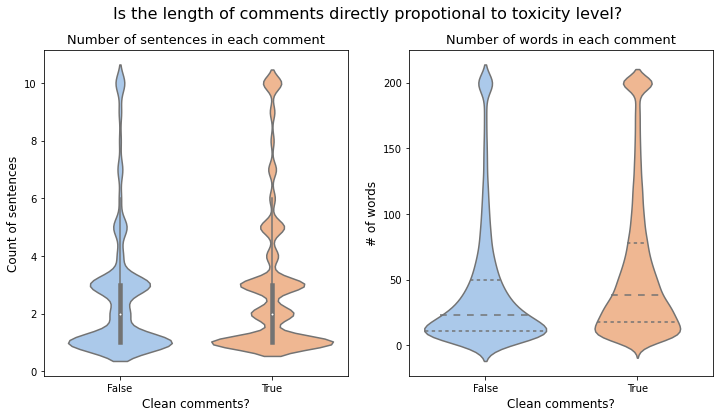

In [54]:
# Create a Violin Plot
train_features['sentence_count'].loc[train_features['sentence_count']>10] = 10 
plt.figure(figsize=(12,6))
## Plot for number of sentences
plt.subplot(121)
plt.suptitle("Is the length of comments directly propotional to toxicity level?",fontsize=16)
sns.violinplot(y='sentence_count',x='clean', data=train_features,split=True, palette="pastel")
plt.xlabel('Clean comments?', fontsize=12)
plt.ylabel('Count of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=13)
# Plot for number of words
train_features['word_count'].loc[train_features['word_count']>200] = 200
plt.subplot(122)
sns.violinplot(y='word_count',x='clean', data=train_features,split=True,inner="quart",  palette="pastel")
plt.xlabel('Clean comments?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=13)

plt.show()

Having more number of words or a longer comment does not indicates toxicity as per the plot above.

In [55]:
# Split for violin plots. Comments less than 30% unique words are considered spam
train_features['unique_word_count'].loc[train_features['unique_word_count']>200] = 200
temp_df = pd.melt(train_features, value_vars=['word_count', 'unique_word_count'], id_vars='clean')
spammers=train_features[train_features['word_unique_percent']<30]

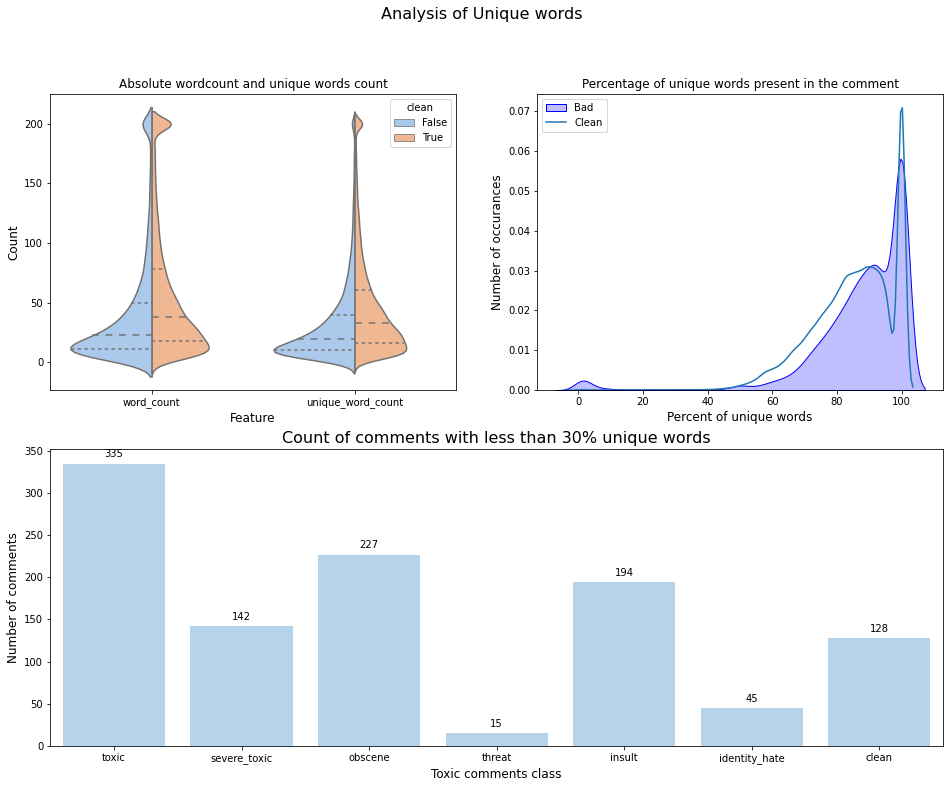

In [63]:
# Draw a violin plot
plt.figure(figsize=(16,12))
plt.suptitle("Analysis of Unique words",fontsize=16)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile', palette="pastel")
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Draw the KDE plot
plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words present in the comment")
ax=sns.kdeplot(train_features[train_features.clean == 0].word_unique_percent, label="Bad",shade=True,color='b')
ax=sns.kdeplot(train_features[train_features.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent of unique words', fontsize=12)

# Draw the bar plot
x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with less than 30% unique words",fontsize=16)
ax=sns.barplot(x=x.index, y=x.values,color="#AED6F1")
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Toxic comments class', fontsize=12)
plt.ylabel('Number of comments', fontsize=12)
plt.show()

From the above plots we analyze the following:
- There are significant shifts in the mean of word count and unique word count across clean and the toxic comments.

- In the violin chart there is a bulge near the 0-10% mark indicating a large number of toxic comments containing very little variety of words.

- In the chart that is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments, there are only 75 clean comments that are spam though the number of clean comments in the dataset are huge (approximately 90%). This seems to be a very good indicator for toxic comment.

#### Leaky Features

In [64]:
# We will mostly use Regex for Leaky features
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
# Get the count of ip addresses and save it in column 'count_ip'
df['count_ip']=df["ip"].apply(lambda x: len(x))

# Get the links and store in 'link' column
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
# Get the count of links and store in 'count_links' column
df['count_links']=df["link"].apply(lambda x: len(x))

# Get the article ids and store in 'article_id' column
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

# Get the username and store in 'username' column
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))

# Get the Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))

# Get the Leaky usernames
cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [66]:
# Let us examine a comment whwre username count is not 0
df[df.count_usernames!=0].comment_text.iloc[0]

'2010]]\n[[User talk:Wikireader41/Archive4|Archive 5-Mar 15'

In [67]:
# Let us check some feature names
cv.get_feature_names()[120:130]

['destruction',
 'diablo',
 'diligent',
 'dland',
 'dlohcierekim',
 'dodo',
 'dominick',
 'douglas',
 'dpl',
 'dr']

Let us check the stability of Leaky Feature by finding the re-occurences of the leaky features and if they are utilized for prediction.

In [68]:
# Filter the columns for leaky features and split in train and test data set
leaky_features=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_features_train=leaky_features.iloc[:train_data.shape[0]]
leaky_features_test=leaky_features.iloc[train_data.shape[0]:]

#### Filter out the text that has no IPs

In [70]:
# Let us filter out the entries that have no ips
train_ips=leaky_features_train.ip[leaky_features_train.count_ip!=0]
test_ips=leaky_features_test.ip[leaky_features_test.count_ip!=0]

In [71]:
# Get the list of unique ips both in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

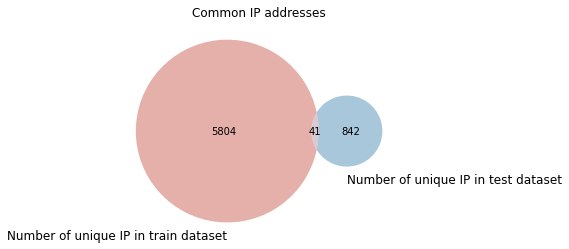

In [91]:
# Fetch the common elements using a Venn digram
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),
           set_labels=("Number of unique IP in train dataset","Number of unique IP in test dataset"),
           set_colors=('#C0392B', '#2874A6'))
plt.show()

#### Filter out the text that has no Links

In [85]:
# Let us filter out the entries that has no links
train_links=leaky_features_train.link[leaky_features_train.count_links!=0]
test_links=leaky_features_test.link[leaky_features_test.count_links!=0]

In [86]:
# Get the list of unique ips in the test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

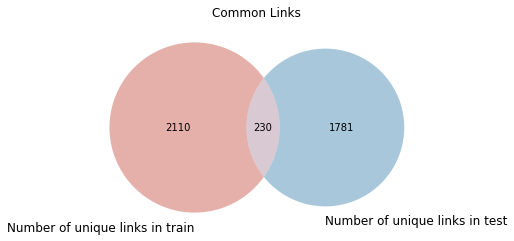

In [90]:
# Fetch the common elements using venn diagram
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common Links")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)),
           set_labels=("Number of unique links in train","Number of unique links in test"),
            set_colors=('#C0392B', '#2874A6'))
plt.show()

#### Filter out the text that has no Users

In [92]:
#Let us filter out the entries that has no users
train_users=leaky_features_train.username[leaky_features_train.count_usernames!=0]
test_users=leaky_features_test.username[leaky_features_test.count_usernames!=0]

In [93]:
# Get the list of unique ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

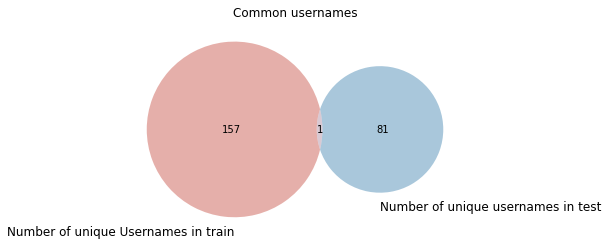

In [94]:
# Fetch common elements using venn diagram
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("Number of unique Usernames in train","Number of unique usernames in test"),
           set_colors=('#C0392B', '#2874A6'))
plt.show()

From the above venn diagrams, we observe that the re-occurence of train dataset usernames in the test dataset is minimal, hence we can use the common links and IPs for train and test.

##### Blocked IPs list

We can also compare the IPs present in our dataset to the available list of IPs that are blocked as given in the following link below:

https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

In [95]:
# get the list of indefinitely blocked IPs from the above link and store them in a variable 'blocked_ips'

blocked_ips=["216.102.6.176",
"216.120.176.2",
"203.25.150.5",
"203.217.8.30",
"66.90.101.58",
"125.178.86.75",
"210.15.217.194",
"69.36.166.207",
"213.25.24.253",
"24.60.181.235",
"71.204.14.32",
"216.91.92.18",
"212.219.2.4",
"194.74.190.162",
"64.15.152.246",
"59.100.76.166",
"146.145.221.129",
"146.145.221.130",
"74.52.44.34",
"68.5.96.201",
"65.184.176.45",
"209.244.43.209",
"82.46.9.168",
"209.200.236.32",
"209.200.229.181",
"202.181.99.22",
"220.233.226.170",
"212.138.64.178",
"220.233.227.249",
"72.14.194.31",
"72.249.45.0/24",
"72.249.44.0/24",
"80.175.39.213",
"81.109.164.45",
"64.157.15.0/24",
"208.101.10.54",
"216.157.200.254",
"72.14.192.14",
"204.122.16.13",
"217.156.39.245",
"210.11.188.16",
"210.11.188.17",
"210.11.188.18",
"210.11.188.19",
"210.11.188.20",
"64.34.27.153",
"209.68.139.150",
"152.163.100.0/24",
"65.175.48.2",
"131.137.245.197",
"131.137.245.199",
"131.137.245.200",
"64.233.172.37",
"66.99.182.25",
"67.43.21.12",
"66.249.85.85",
"65.175.134.11",
"201.218.3.198",
"193.213.85.12",
"131.137.245.198",
"83.138.189.74",
"72.14.193.163",
"66.249.84.69",
"209.204.71.2",
"80.217.153.189",
"83.138.136.92",
"83.138.136.91",
"83.138.189.75",
"83.138.189.76",
"212.100.250.226",
"212.100.250.225",
"212.159.98.189",
"87.242.116.201",
"74.53.243.18",
"213.219.59.96/27",
"212.219.82.37",
"203.38.149.226",
"66.90.104.22",
"125.16.137.130",
"66.98.128.0/17",
"217.33.236.2",
"24.24.200.113",
"152.22.0.254",
"59.145.89.17",
"71.127.224.0/20",
"65.31.98.71",
"67.53.130.69",
"204.130.130.0/24",
"72.14.193.164",
"65.197.143.214",
"202.60.95.235",
"69.39.89.95",
"88.80.215.14",
"216.218.214.2",
"81.105.175.201",
"203.108.239.12",
"74.220.207.168",
"206.253.55.206",
"206.253.55.207",
"206.253.55.208",
"206.253.55.209",
"206.253.55.210",
"66.64.56.194",
"70.91.90.226",
"209.60.205.96",
"202.173.191.210",
"169.241.10.83",
"91.121.195.205",
"216.70.136.88",
"72.228.151.208",
"66.197.167.120",
"212.219.232.81",
"208.86.225.40",
"63.232.20.2",
"206.219.189.8",
"212.219.14.0/24",
"165.228.71.6",
"99.230.151.129",
"72.91.11.99",
"173.162.177.53",
"60.242.166.182",
"212.219.177.34",
"12.104.27.5",
"85.17.92.13",
"91.198.174.192/27",
"155.246.98.61",
"71.244.123.63",
"81.144.152.130",
"198.135.70.1",
"71.255.126.146",
"74.180.82.59",
"206.158.2.80",
"64.251.53.34",
"24.29.92.238",
"76.254.235.105",
"68.96.242.239",
"203.202.234.226",
"173.72.89.88",
"87.82.229.195",
"68.153.245.37",
"216.240.128.0/19",
"72.46.129.44",
"66.91.35.165",
"82.71.49.124",
"69.132.171.231",
"75.145.183.129",
"194.80.20.237",
"98.207.253.170",
"76.16.222.162",
"66.30.100.130",
"96.22.29.23",
"76.168.140.158",
"202.131.166.252",
"89.207.212.99",
"81.169.155.246",
"216.56.8.66",
"206.15.235.10",
"115.113.95.20",
"204.209.59.11",
"27.33.141.67",
"41.4.65.162",
"99.6.65.6",
"60.234.239.169",
"2620:0:862:101:0:0:2:0/124",
"183.192.165.31",
"50.68.6.12",
"37.214.82.134",
"96.50.0.230",
"60.231.28.109",
"64.90.240.50",
"49.176.97.12",
"209.80.150.137",
"24.22.67.116",
"206.180.81.2",
"195.194.39.100",
"87.41.52.6",
"169.204.164.227",
"50.137.55.117",
"50.77.84.161",
"90.202.230.247",
"186.88.129.224",
"2A02:EC80:101:0:0:0:2:0/124",
"142.4.117.177",
"86.40.105.198",
"120.43.20.149",
"198.199.64.0/18",
"192.34.56.0/21",
"192.81.208.0/20",
"2604:A880:0:0:0:0:0:0/32",
"108.72.107.229",
"2602:306:CC2B:7000:41D3:B92D:731C:959D",
"185.15.59.201",
"180.149.1.229",
"207.191.188.66",
"210.22.63.92",
"117.253.196.217",
"119.160.119.172",
"90.217.133.223",
"194.83.8.3",
"194.83.164.22",
"217.23.228.149",
"65.18.58.1",
"168.11.15.2",
"65.182.127.31",
"207.106.153.252",
"64.193.88.2",
"152.26.71.2",
"199.185.67.179",
"117.90.240.73",
"108.176.58.170",
"195.54.40.28",
"185.35.164.109",
"192.185.0.0/16",
"2605:E000:1605:C0C0:3D3D:A148:3039:71F1",
"107.158.0.0/16",
"85.159.232.0/21",
"69.235.4.10",
"86.176.166.206",
"108.65.152.51",
"10.4.1.0/24",
"103.27.227.139",
"188.55.31.191",
"188.53.13.34",
"176.45.58.252",
"176.45.22.37",
"24.251.44.140",
"108.200.140.191",
"117.177.169.4",
"72.22.162.38",
"24.106.242.82",
"79.125.190.93",
"107.178.200.1",
"123.16.244.246",
"83.228.167.87",
"128.178.197.53",
"14.139.172.18",
"207.108.136.254",
"184.152.17.217",
"186.94.29.73",
"217.200.199.2",
"66.58.141.104",
"166.182.81.30",
"89.168.206.116",
"92.98.163.145",
"77.115.31.71",
"178.36.118.74",
"157.159.10.14",
"103.5.212.139",
"203.174.180.226",
"69.123.252.95",
"199.200.123.233",
"121.45.89.82",
"71.228.87.155",
"68.189.67.92",
"216.161.176.152",
"98.17.30.139",
"2600:1006:B124:84BD:0:0:0:103",
"117.161.0.0/16",
"12.166.68.34",
"96.243.149.64",
"74.143.90.218",
"76.10.176.221",
"104.250.128.0/19",
"185.22.183.128/25",
"89.105.194.64/26",
"202.45.119.0/24",
"73.9.140.64",
"164.127.71.72",
"50.160.129.2",
"49.15.213.207",
"83.7.192.0/18",
"201.174.63.79",
"2A02:C7D:4643:8F00:D09D:BE1:D2DE:BB1F",
"125.60.195.230",
"49.145.113.145",
"168.18.160.134",
"72.193.218.222",
"199.216.164.10",
"120.144.130.89",
"104.130.67.208",
"50.160.221.147",
"163.47.141.50",
"91.200.12.136",
"83.222.0.0/19",
"67.231.16.0/20",
"72.231.0.196",
"180.216.68.197",
"183.160.178.135",
"183.160.176.16",
"24.25.221.150",
"92.222.109.43",
"142.134.243.215",
"216.181.221.72",
"113.205.170.110",
"74.142.2.98",
"192.235.8.3",
"2402:4000:BBFC:36FC:E469:F2F0:9351:71A0",
"80.244.81.191",
"2607:FB90:1377:F765:D45D:46BF:81EA:9773",
"2600:1009:B012:7D88:418B:54BA:FCBC:4584",
"104.237.224.0/19",
"2600:1008:B01B:E495:C05A:7DD3:926:E83C",
"168.8.249.234",
"162.211.179.36",
"138.68.0.0/16",
"145.236.37.195",
"67.205.128.0/18",
"2A02:C7D:2832:CE00:B914:19D6:948D:B37D",
"107.77.203.212",
"2607:FB90:65C:A136:D46F:23BA:87C2:3D10",
"2A02:C7F:DE2F:7900:5D64:E991:FFF0:FA93",
"82.23.32.186",
"106.76.243.74",
"82.33.48.223",
"180.216.160.0/19",
"94.102.184.35",
"94.102.184.26",
"109.92.162.54",
"2600:8800:7180:BF00:4C27:4591:347C:736C",
"178.41.186.50",
"184.97.134.128",
"176.221.32.0/22",
"207.99.40.142",
"109.97.241.134",
"82.136.64.19",
"91.236.74.119",
"197.210.0.0/16",
"173.230.128.0/19",
"162.216.16.0/22",
"80.111.222.211",
"191.37.28.21",
"124.124.103.194",
"50.207.7.198",
"220.233.131.98",
"107.77.241.11",
"68.112.39.0/27",
"173.236.128.0/17",
"49.49.240.24",
"96.31.10.178",
"50.251.229.75"]

In [97]:
# Get the ip list from train and test ips
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

In [98]:
# Fetch the Ips that are common to blocked IP list
blocked_ip_list_train=list(set(train_ip_list).intersection(blocked_ips))
blocked_ip_list_test=list(set(test_ip_list).intersection(blocked_ips))

In [99]:
# Display the result
print("There are",len(blocked_ip_list_train),"blocked IPs in train dataset")
print("There are",len(blocked_ip_list_test),"blocked IPs in test dataset")

There are 6 blocked IPs in train dataset
There are 0 blocked IPs in test dataset


We observe that there are only 6 blocked IPs in the train dataset and no blocked IPs in test dataset, hence this would not be very significant.

# Data Cleaning

Now let us perform data cleaning which is a very important part for efficient model training.

In [100]:
# store the comments text in a variable called 'corpus'
corpus=merged_df.comment_text

In [101]:
# Create a dictionary of Aphost lookup
APHOST_LOOKUP = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

#### Define a function that does the whole bunch of data cleaning for the comments texts like:
- converting to lower case
- removing new line 
- removing Ips and users
- tokenize the comments into words
- Apostrophe replacement and dictionary lookup
- Stop words removal
- Lemmatization

In [102]:
# Define the function for data cleaning
def clean_data_pipeline(comment):
    comment=comment.lower() # Convert to lower case
    comment=re.sub("\\n","",comment) # Remove new line
    # Remove the leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    comment=re.sub("\[\[.*\]","",comment) # Remove users
    words=tokenizer.tokenize(comment) # Tokenize into words
    # Replace apostrophe with reference to the Aphost Dictionary 
    words=[APHOST_LOOKUP[word] if word in APHOST_LOOKUP else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words] # Lemmatization
    words = [w for w in words if not w in eng_stopwords] # Remove stopwords
    clean_sent=" ".join(words)
    return(clean_sent)

In [112]:
# Let us examine any one comment
corpus.iloc[772]

'"\n\n""Actions in la-la land have real world consequences"". 190.67.223.50  "'

In [113]:
# Let us now examine the same comment after passing through the cleaning pipeline
clean_data_pipeline(corpus.iloc[772])

'" " " action la-la land real world consequences " " . "'

In [114]:
# Clean the entire corpus now
clean_corpus=corpus.apply(lambda x :clean_data_pipeline(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 23176.698395490646


#### After cleaning the corpus let us now use this cleaned corpus for analyzing Direct features, in fact count based features (unigrams) and will use:
- CountVectorizer
- TF-IDF Vectorizer 
- HashingVectorizer


In [115]:
# TF-IDF Vectorizer
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train_data.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train_data.shape[0]:])

In [117]:
# define a function for top tf-idf values and return a mapped value with feature names
def top_tfidf_features(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [118]:
# define a function for top features in a specific document
def top_featuress_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_features(row, features, top_n)

In [119]:
# Define a function to return top features based on average
def top_mean_features(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    D = Xtr[grp_ids].toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)

In [120]:
# Define a function modified for multi-label milti-class
def top_features_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [147]:
# Get top n for unigrams
tfidf_top_n_per_class=top_features_by_class(train_unigrams,features)
end_unigrams=time.time()
print("total time in unigrams",end_unigrams-start_unigrams)
print("total time till unigrams",end_unigrams-start_time)

total time in unigrams 2334.9450702667236
total time till unigrams 26466.128403186798


In [148]:
# Define a function for TF-IDF subplot
def subplot_tfidf(label="Toxic", loc=(0,0), colour="#EB984E",ilocy=9, spancol=0, top_n=0):
  if(spancol>0):
    plt.subplot2grid((4,2),loc, colspan=spancol)
  else:
    plt.subplot2grid((4,2),loc)
  sns.barplot(tfidf_top_n_per_class[top_n].feature.iloc[0:ilocy],tfidf_top_n_per_class[top_n].tfidf.iloc[0:ilocy],color=colour)
  plt.title("class : "+label,fontsize=13)
  plt.xlabel('Word', fontsize=12)
  plt.ylabel('TF-IDF score', fontsize=12)

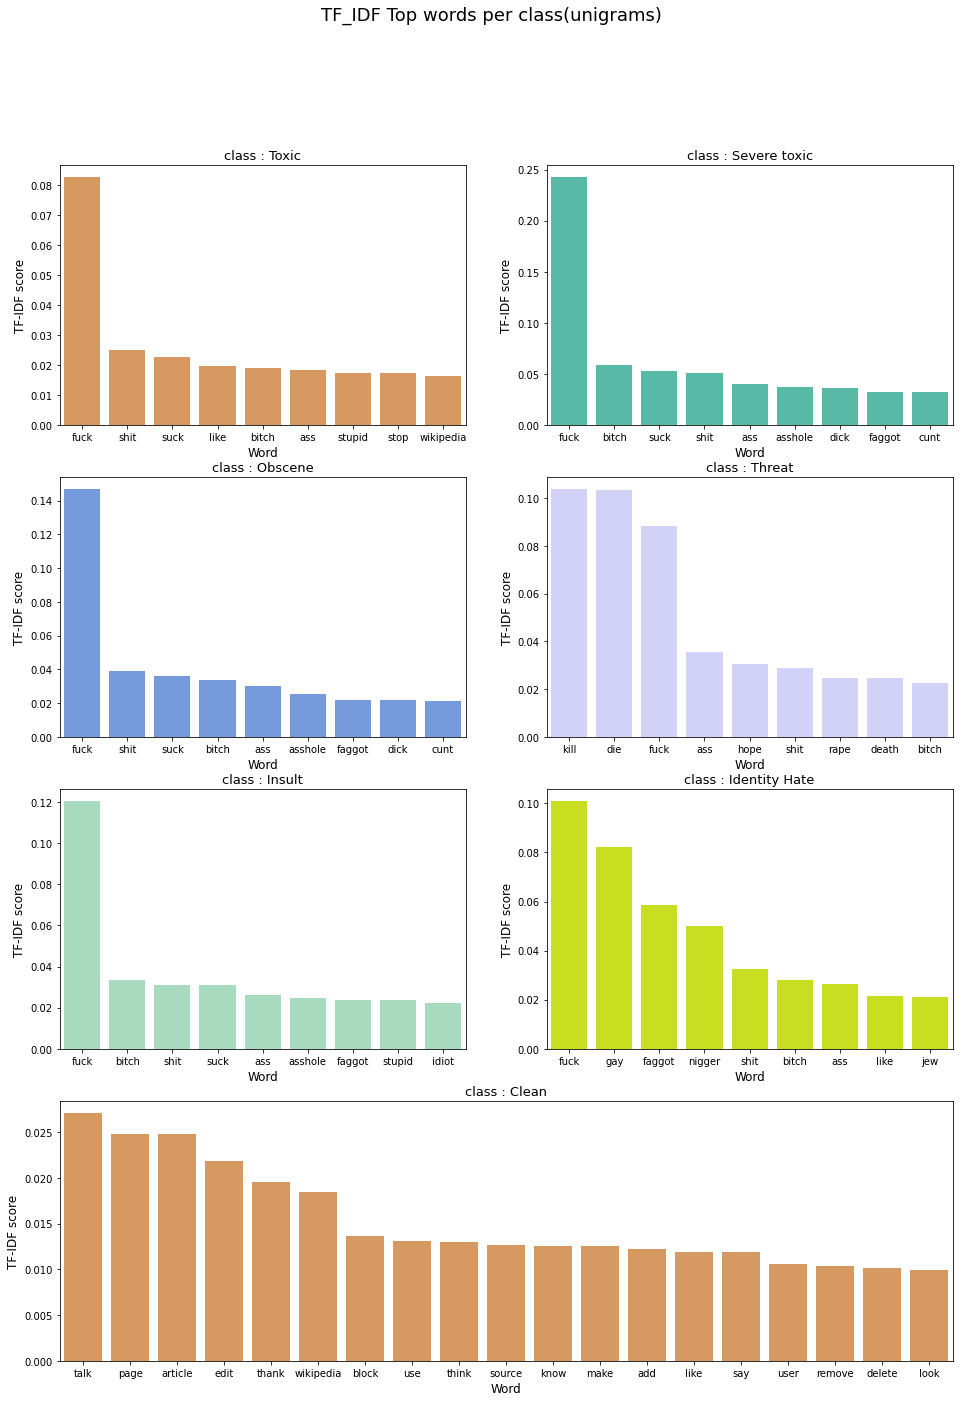

In [152]:
# Draw all the plots
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=18)
gridspec.GridSpec(4,2)
subplot_tfidf()
subplot_tfidf(label="Severe toxic", loc=(0,1), colour="#48C9B0", top_n=1)
subplot_tfidf(label="Obscene", loc=(1,0), colour="#6495ED", top_n=2)
subplot_tfidf(label="Threat", loc=(1,1), colour="#CCCCFF", top_n=3)
subplot_tfidf(label="Insult", loc=(2,0), colour="#9FE2BF", top_n=4)
subplot_tfidf(label="Identity Hate", loc=(2,1), colour="#DFFF00", top_n=5)
subplot_tfidf(label="Clean", loc=(3,0), colour="#EB984E",ilocy=19, spancol=2, top_n=6)
plt.show()

In [153]:
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train_data.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train_data.shape[0]:])

In [ ]:
# Get the top n for bigrams
tfidf_top_n_per_class=top_features_by_class(train_bigrams,features)

In [155]:
def tfidf_bigram_plot(label="Toxic", loc=(0,0), colour="#EB984E",ilocy=5, spancol=0, top_n=0):
  if(spancol>0):
    plt.subplot2grid((4,2),loc, colspan=spancol)
  else:
     plt.subplot2grid((4,2),loc)
  sns.barplot(tfidf_top_n_per_class[top_n].feature.iloc[0:ilocy],tfidf_top_n_per_class[top_n].tfidf.iloc[0:ilocy],color=colour)
  plt.title("class : "+label,fontsize=15)
  plt.xlabel('Word', fontsize=12)
  plt.ylabel('TF-IDF score', fontsize=12)

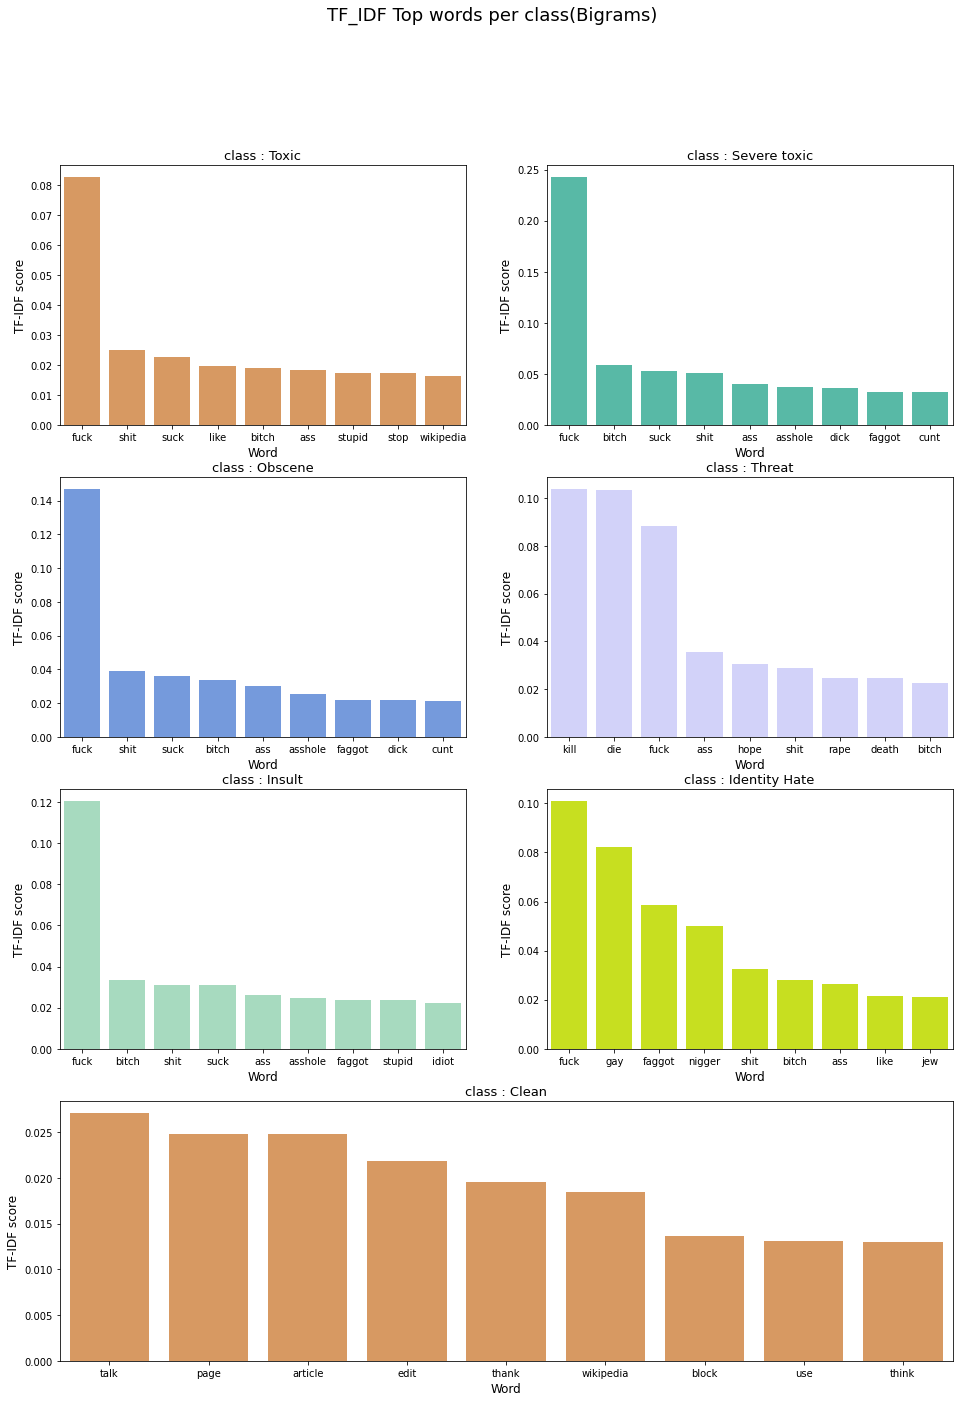

In [156]:
# Draw all the plots
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=18)
gridspec.GridSpec(4,2)
subplot_tfidf()
subplot_tfidf(label="Severe toxic", loc=(0,1), colour="#48C9B0", top_n=1)
subplot_tfidf(label="Obscene", loc=(1,0), colour="#6495ED", top_n=2)
subplot_tfidf(label="Threat", loc=(1,1), colour="#CCCCFF", top_n=3)
subplot_tfidf(label="Insult", loc=(2,0), colour="#9FE2BF", top_n=4)
subplot_tfidf(label="Identity Hate", loc=(2,1), colour="#DFFF00", top_n=5)
subplot_tfidf(label="Clean", loc=(3,0), colour="#EB984E",ilocy=9, spancol=2, top_n=6)
plt.show()

In [157]:
end_time=time.time()
print("total time till bigrams",end_time-start_time)

total time till bigrams 27631.349564790726


In [158]:
tfv = TfidfVectorizer(min_df=100,  max_features=30000, 
            strip_accents='unicode', analyzer='char',ngram_range=(1,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_charngrams =  tfv.transform(clean_corpus.iloc[:train_data.shape[0]])
test_charngrams = tfv.transform(clean_corpus.iloc[train_data.shape[0]:])
end_time=time.time()
print("total time till charngrams",end_time-start_time)

total time till charngrams 28172.97981286049


#### We are done with EDA, Data Cleaning and Feature Engineering, so let us now train our model with the following Algorithms and check as which algorithms performs the best:
- Logistic Regression
- Decision Tree
- LSTM
- BERT

## Logistic Regression

In [161]:
# create the toxic columns list
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [162]:
# Let us clean comment_text for train and test data
train_data["comment_text"] = train_data.comment_text.apply(lambda x :clean_data_pipeline(x))
test_data["comment_text"] = test_data.comment_text.apply(lambda x :clean_data_pipeline (x))

In [163]:
# Let us store the train and test comment text in the variables to be used later
X_train = train_data.comment_text
X_test = test_data.comment_text

In [164]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [165]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3082501 stored elements in Compressed Sparse Row format>

In [166]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(X_test)
# examine the document-term matrix from X_test
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2594452 stored elements in Compressed Sparse Row format>

In [168]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

In [169]:
# Train the model and check the accuracy
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_data[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]

... Processing obscene
Training accuracy is 0.9833491047872107
... Processing insult
Training accuracy is 0.9758665421661831
... Processing toxic
Training accuracy is 0.9647116330661586
... Processing severe_toxic
Training accuracy is 0.9919596919239712
... Processing identity_hate
Training accuracy is 0.9936642623033007
... Processing threat
Training accuracy is 0.9979632890688158


## Decision Tree Classifier

In [ ]:
# Load the data
#data_path = "data/train.csv"
#data = pd.read_csv(data_path)

In [170]:
# Split the train data into training and testing sets
train_df, test_df = train_test_split(train_data, test_size=0.2, random_state=42)

In [171]:
# Preprocess the data using TF-IDF vectorization
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_df.comment_text)
test_features = vectorizer.transform(test_df.comment_text)

In [173]:
# Train a Decision Tree classifier on the training data
clf = DecisionTreeClassifier()
clf.fit(train_features, train_df.toxic)

DecisionTreeClassifier()

In [174]:
# Predict on the testing data and measure accuracy
test_pred = clf.predict(test_features)
acc = accuracy_score(test_df.toxic, test_pred)
print("The accuracy is: {:.2f}%".format(acc*100))

The accuracy is: 94.15%


## LSTM

In [ ]:
# Load the data
#data_path = "data/train.csv"
#data = pd.read_csv(data_path)

In [ ]:
# Split the data into training and testing sets
#train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [175]:
# Preprocess the data using Keras Tokenizer
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(train_df.comment_text)
train_sequences = tokenizer.texts_to_sequences(train_df.comment_text)
test_sequences = tokenizer.texts_to_sequences(test_df.comment_text)

In [176]:
# Pad the sequences to make them the same length
max_len = 100
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post")

In [177]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(5000, 128, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [178]:
# Train the model on the training data
model.fit(train_padded, train_df.toxic, validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
3192/3192 [==============================] - 1199s 374ms/step - loss: 0.3116 - accuracy: 0.9052 - val_loss: 0.2521 - val_accuracy: 0.9040
Epoch 2/5
3192/3192 [==============================] - 1195s 375ms/step - loss: 0.1550 - accuracy: 0.9429 - val_loss: 0.1296 - val_accuracy: 0.9570
Epoch 3/5
3192/3192 [==============================] - 1211s 379ms/step - loss: 0.1169 - accuracy: 0.9573 - val_loss: 0.1173 - val_accuracy: 0.9603
Epoch 4/5
3192/3192 [==============================] - 1232s 386ms/step - loss: 0.1002 - accuracy: 0.9627 - val_loss: 0.1187 - val_accuracy: 0.9588
Epoch 5/5
3192/3192 [==============================] - 1227s 384ms/step - loss: 0.0904 - accuracy: 0.9656 - val_loss: 0.1209 - val_accuracy: 0.9597


In [179]:
# Evaluate the model on the testing data
test_pred = model.predict(test_padded)
acc = accuracy_score(test_df.toxic, np.argmax(test_pred, axis=1))
print("The accuracy: {:.2f}%".format(acc*100))

998/998 [==============================] - 50s 49ms/step
The accuracy: 90.42%


In [180]:
# Let us save the cleaned train and test data
train_data.to_csv("train_data_cleaned.csv")
test_data.to_csv("test_data_cleaned.csv")

## BERT